In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from scipy.stats import spearmanr as spearman
pilot_file = "Batch_3198536_batch_results.csv"
import warnings
warnings.filterwarnings('ignore')

#### R packages install - Run only if running for the first time

In [2]:
# import rpy2.robjects.packages as rpackages
# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1) 
# packnames = ('ggplot2', 'lme4', 'reshape2', 'tidyverse')
# from rpy2.robjects.vectors import StrVector
# utils.install_packages(StrVector(packnames))

In [3]:
#Load R packages:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [4]:
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]
#data.head()

In [5]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_instant = "Answer_instantaneous" + str(idx+1)
            var_instant_c =  "Answer_confidence_instantaneous" + str(idx+1)
            var_start = "Answer_startpt" + str(idx+1)
            var_start_c = "Answer_confidence_startpoint" + str(idx+1)
            var_end = "Answer_endpt" + str(idx+1)
            var_end_c = "Answer_confidence_endpoint" + str(idx+1)
            var_duration = "Answer_duration" + str(idx+1)
            var_duration_c = "Answer_confidence_duration" + str(idx+1)

            temp_dict["is_instant"] = getattr(row, var_instant)
            temp_dict["conf_instant"] = getattr(row, var_instant_c)
            temp_dict["has_start"] = getattr(row, var_start)
            temp_dict["conf_start"] = getattr(row, var_start_c)
            temp_dict["has_end"] = getattr(row, var_end)
            temp_dict["conf_end"] = getattr(row, var_end_c)
            temp_dict["duration"] = getattr(row, var_duration)
            temp_dict["conf_duration"] = getattr(row, var_duration_c)
            temp_dict["worker_id"] = row.WorkerId
            temp_dict["hit_id"] = row.HITId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)


In [6]:
pilot_data = extract_dataframe(data)

#Re-arrange the order 
cols = list(pilot_data.columns)
pilot_data = pilot_data[pilot_data.columns[::-1]].drop('sentence', axis=1)

#pilot_data.replace('na',np.NaN, inplace=True)
pilot_data.head
pilot_data['sent_token'] = pilot_data['sentence_id'] + "_" +\
                            pilot_data['pred_token'].map(lambda x: str(x))


In [7]:
#Convert datatypes to be consistent
pilot_data = pilot_data.convert_objects(convert_numeric=True)
pilot_data.fillna(-1, inplace=True)
pilot_data['conf_start'] = pilot_data['conf_start'].astype(np.int64)
pilot_data['conf_end'] = pilot_data['conf_end'].astype(np.int64)
pilot_data['conf_duration'] = pilot_data['conf_duration'].astype(np.int64)
pilot_data['duration'] = pilot_data['duration'].astype(np.int64)
pilot_data.dtypes

worker_id        object
sentence_id      object
pred_token        int64
pred             object
is_instant         bool
id                int64
hit_id           object
has_start        object
has_end          object
duration          int64
conf_start        int64
conf_instant      int64
conf_end          int64
conf_duration     int64
sent_token       object
dtype: object

In [8]:
#Change has_start and Has_end to True if instantaneous = True
pilot_data.loc[(pilot_data.is_instant == True), 
               ['has_start', 'has_end']] = "true", "true"

pilot_data.loc[(pilot_data.is_instant == True), 'conf_start'] = pilot_data.conf_instant
pilot_data.loc[(pilot_data.is_instant == True), 'conf_end'] = pilot_data.conf_instant


In [9]:
pilot_data.head()

,worker_id,sentence_id,pred_token,pred,is_instant,id,hit_id,has_start,has_end,duration,conf_start,conf_instant,conf_end,conf_duration,sent_token
0,AQ2U4H38MELRY,en-ud-train.conllu 5784,3,occurred,True,1,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,true,true,-1,2,2,2,-1,en-ud-train.conllu 5784_3
1,AQ2U4H38MELRY,en-ud-train.conllu 5784,5,processing,False,2,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,true,false,7,3,2,2,2,en-ud-train.conllu 5784_5
2,AQ2U4H38MELRY,en-ud-train.conllu 1010,3,held,False,3,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,1,3,2,0,en-ud-train.conllu 1010_3
3,AQ2U4H38MELRY,en-ud-train.conllu 1010,15,curating,False,4,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,2,4,2,1,en-ud-train.conllu 1010_15
4,AQ2U4H38MELRY,en-ud-train.conllu 5106,20,acted,False,5,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,3,2,3,0,en-ud-train.conllu 5106_20


#### Run Mixed Effects Model in R

In [10]:
# Enables the %%R magic 
%load_ext rpy2.ipython

In [11]:
#load packages:
%R require(ggplot2); require(tidyr); require(lme4)
# library(sigmoid)
# library(reshape2)
# library(tidyverse)

array([1], dtype=int32)

##### Process Data in R

### Run Mixed Effects Model 

#### Is Instant

In [12]:
%%R -i pilot_data -o df_inst
#Modelling Is_instant

#Convert to factors
pilot_data$is_instant = as.factor(pilot_data$is_instant)
pilot_data$has_start = as.factor(pilot_data$has_start)
pilot_data$has_end = as.factor(pilot_data$has_end)

#Mixed Effects Model
model = glmer(is_instant~1+(1|worker_id) + (1|sent_token) + (1|hit_id), data=pilot_data,  family="binomial")

#Model intercepts:
df_inst = ranef(model)$worker_id
colnames(df_inst) <- c('intercept')

df_inst$glmer_intercept_inst = df_inst$intercept + -0.4101 #constant added manually
df_inst$worker_id <- rownames(df_inst) 

print(summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_instant ~ 1 + (1 | worker_id) + (1 | sent_token) + (1 | hit_id)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
  1163.9   1183.5   -577.9   1155.9      996 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6394 -0.5412 -0.2856  0.5915  3.8726 

Random effects:
 Groups     Name        Variance Std.Dev.
 sent_token (Intercept) 2.205    1.485   
 worker_id  (Intercept) 1.567    1.252   
 hit_id     (Intercept) 0.000    0.000   
Number of obs: 1000, groups:  sent_token, 200; worker_id, 72; hit_id, 20

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -0.4101     0.2033  -2.018   0.0436 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


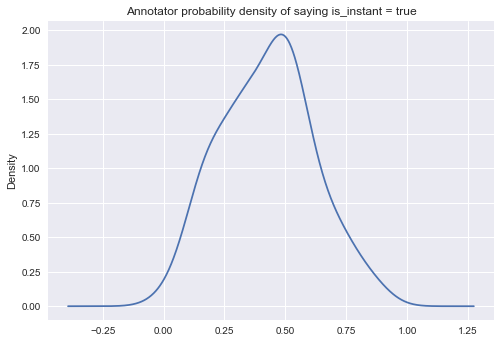

In [13]:
df_inst['glmer_intercept_inst'] = df_inst['glmer_intercept_inst'].apply(lambda x: 1/(1+np.exp(-x)))
df_inst.glmer_intercept_inst.plot(kind='density')
plt.title("Annotator probability density of saying is_instant = true")
plt.show()

#### Has_Start

In [14]:
%%R -i pilot_data -o df_start
#Modelling Is_instant

#Convert to factors
pilot_data$is_instant = as.factor(pilot_data$is_instant)
pilot_data$has_start = as.factor(pilot_data$has_start)
pilot_data$has_end = as.factor(pilot_data$has_end)

#Mixed Effects Model
model = glmer(has_start~1+(1|worker_id) + (1|sent_token) + (1|hit_id), data=pilot_data,  family="binomial")

#Model intercepts:
df_start = ranef(model)$worker_id
colnames(df_start) <- c('intercept')

df_start$glmer_intercept_start = df_start$intercept + 1.1608 #constant added manually
df_start$worker_id <- rownames(df_start) 

print(summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: has_start ~ 1 + (1 | worker_id) + (1 | sent_token) + (1 | hit_id)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
  1169.0   1188.6   -580.5   1161.0      996 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4626 -0.6630  0.3436  0.5591  1.9087 

Random effects:
 Groups     Name        Variance Std.Dev.
 sent_token (Intercept) 1.1616   1.0778  
 worker_id  (Intercept) 1.5156   1.2311  
 hit_id     (Intercept) 0.2094   0.4576  
Number of obs: 1000, groups:  sent_token, 200; worker_id, 72; hit_id, 20

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.1608     0.2198   5.282 1.28e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


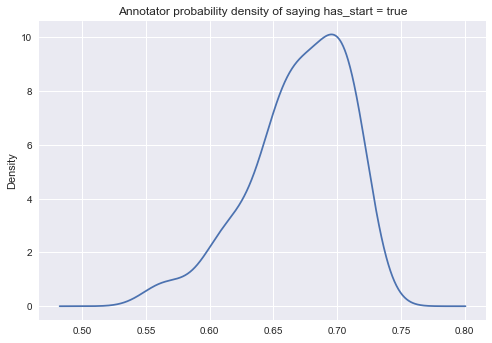

In [16]:
df_start['glmer_intercept_start'] = df_start['glmer_intercept_start'].apply(lambda x: 1/(1+np.exp(-x)))
df_start.glmer_intercept_start.plot(kind='density')
plt.title("Annotator probability density of saying has_start = true")
plt.show()

#### Has_End

In [17]:
%%R -i pilot_data -o df_end
#Modelling Is_instant

#Convert to factors
pilot_data$is_instant = as.factor(pilot_data$is_instant)
pilot_data$has_start = as.factor(pilot_data$has_start)
pilot_data$has_end = as.factor(pilot_data$has_end)

#Mixed Effects Model
model = glmer(has_end~1+(1|worker_id) + (1|sent_token) + (1|hit_id), data=pilot_data,  family="binomial")

#Model intercepts:
df_end = ranef(model)$worker_id
colnames(df_end) <- c('intercept')

df_end$glmer_intercept_end = df_end$intercept + 0.8758 #constant added manually
df_end$worker_id <- rownames(df_end) 

print(summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: has_end ~ 1 + (1 | worker_id) + (1 | sent_token) + (1 | hit_id)
   Data: pilot_data

     AIC      BIC   logLik deviance df.resid 
  1223.6   1243.2   -607.8   1215.6      996 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1943 -0.6887  0.3885  0.5902  1.8611 

Random effects:
 Groups     Name        Variance  Std.Dev. 
 sent_token (Intercept) 1.217e+00 1.1031692
 worker_id  (Intercept) 1.108e+00 1.0525183
 hit_id     (Intercept) 4.944e-07 0.0007032
Number of obs: 1000, groups:  sent_token, 200; worker_id, 72; hit_id, 20

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.8758     0.1748   5.012  5.4e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
convergence code: 0
Model failed to converge with max|grad| = 0.00284863 (tol = 0.001, component 1)



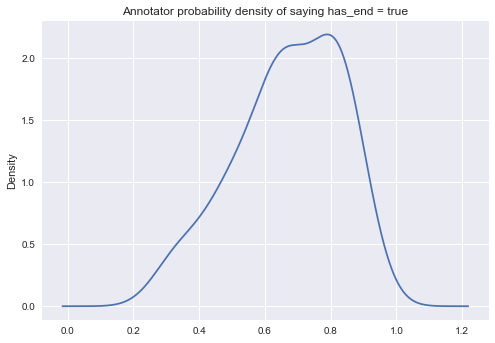

In [18]:
df_end['glmer_intercept_end'] = df_end['glmer_intercept_end'].apply(lambda x: 1/(1+np.exp(-x)))
df_end.glmer_intercept_end.plot(kind='density')
plt.title("Annotator probability density of saying has_end = true")
plt.show()

On the data saved above, run mler models in R to determine values for is_instant, has_start, has_end for each sentence_predicate pair

## Response distribution

In [ ]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10))
sns.countplot(x='is_instant', data=pilot_data, ax=axs[0][0])
sns.countplot(x='conf_instant', data=pilot_data, ax=axs[0][1])
sns.countplot(x='has_start', data=pilot_data, ax=axs[0][2])
sns.countplot(x='conf_start', data=pilot_data, ax=axs[0][3])
sns.countplot(x='has_end', data=pilot_data, ax=axs[1][0])
sns.countplot(x='conf_end', data=pilot_data, ax=axs[1][1])
sns.countplot(x='duration', data=pilot_data, ax=axs[1][2])
sns.countplot(x='conf_duration', data=pilot_data, ax=axs[1][3])
plt.show()

## Inter-Annotator Agreement

### Raw Agreement

 #### 1. Stringent (Exact matches for a particular sent-predicate pair)

In [ ]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys

instant_agreement, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'is_instant')
start_agreement, key_start = calc_raw_agreement(pilot_data, 'sent_token', 'has_start')
end_agreement, key_end = calc_raw_agreement(pilot_data, 'sent_token', 'has_end')

#### 2. Kappa score estimation

In [ ]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def extract_worker_pair_dict(data, worker_pairs, worker_dict, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    ans = {}
    
    for (w1, w2) in worker_pairs:
        common_set = worker_dict[w1].intersection(worker_dict[w2])
        if common_set != set():
            ans[(w1,w2)] = list(common_set)
        
    return ans

In [ ]:
worker_pairs = extract_pairs_of_workers(pilot_data, 'worker_id')
worker_dict = extract_worker_sent_dict(pilot_data, 'worker_id', 'sent_token')
worker_pair_dict = extract_worker_pair_dict(pilot_data, worker_pairs, worker_dict,'sent_token')

In [ ]:
columns = ['annotator1', 'annotator2', 'sent_token']
df_workers = pd.DataFrame(index=range(len(worker_pair_dict)), columns=columns)

In [ ]:
worker_pair_dict


In [ ]:
index = 0
for pair in worker_pair_dict:
    for sent_token in worker_pair_dict[pair]:
        df_workers.loc[index,'annotator1'] = pair[0]
        df_workers.loc[index,'annotator2'] = pair[1]
        df_workers.loc[index,'sent_token'] = sent_token
        index +=1

In [ ]:
df_workers['hit_id'] = 

In [ ]:
kappas = {}
alphas = {}
vars_temp = ['is_instant', 'modified_instant', 'modified_instant3']
for var in vars_temp:
    kappas[var], alphas[var] = average_metric_nltk(pilot_data, 'worker_id', 'sent_token', var)
    print("{} -- Completed!".format(var))


In [ ]:
# corrs = {}
# vars1 = ['is_instant', 'has_start', 'has_end', 
#              'modified_instant',  'modified_instant2', 'modified_instant3', 'modified_instant4']
# vars2 = ['duration','conf_instant', 'conf_start', 'conf_end', 'conf_duration']
# for var in vars2:
#     corrs[var] = average_correlation(pilot_data, 'worker_id', 'sent_pred', var)
#     print("{} -- Completed!".format(var))
    

In [ ]:
kappa_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kappas.items() ]))
alpha_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in alphas.items() ]))

In [ ]:
kappa_data.head()

In [ ]:
print('Average Kappa for "is_instant" variable: {}'.format(np.mean(kappa_data['is_instant'])))
print('Average Kappa for "modified_instant" variable: {}'.format(np.mean(kappa_data['modified_instant'])))
#print('Average Kappa for "modified_instant2" variable: {}'.format(np.mean(kappa_data['modified_instant2'])))
print('Average Kappa for "modified_instant3" variable: {}'.format(np.mean(kappa_data['modified_instant3'])))
#print('Average Kappa for "modified_instant4" variable: {}'.format(np.mean(kappa_data['modified_instant4'])))
#print('Average Kappa for "modified_instant5" variable: {}'.format(np.mean(kappa_data['modified_instant5'])))
print("\n")
#print('Average accuracy for "is_instant" variable: {}'.format(np.mean(acc_data['is_instant'])))
#print('Average accuracy for "has_start" variable: {}'.format(np.mean(acc_data['has_start'])))
#print('Average accuracy for "has_end" variable: {}'.format(np.mean(acc_data['has_end'])))

In [ ]:
ax = sns.boxplot(data=kappa_data)
ax.set(title="Average Kappa Score")
plt.show()

ax = sns.boxplot(data=alpha_data)
ax.set(title="Average Alphas")
plt.show()

# ax = sns.boxplot(data=corrs_data)
# ax.set(title="Average Spearman Correlation")
# plt.show()

In [ ]:
pilot_data['weight_duration'] = pilot_data.groupby('worker_id').duration.apply(lambda x: x.rank()/len(x))